In [ ]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def data_generator(m, s, N, seed=None):
    """
    Generates a two-class, two-dimensional dataset using four normal distributions.
    The first two distributions belong to class +1, the last two belong to class -1.

    Parameters:
    - m: 2x4 matrix, where each column is the mean vector for a distribution.
    - s: Variance parameter (controls spread of points).
    - N: Number of points per distribution.
    - seed: Random seed for reproducibility.

    Returns:
    - X: 2x(4*N) NumPy array of data points.
    - y: (4*N,) NumPy array of class labels.
    """
    if seed is not None:
        np.random.seed(seed)  # Ensure reproducibility

    X = []
    y = []
    S = s * np.eye(2)

    for i in range(4):
        mean = np.array(m)[:, i]  # Extract the i-th mean vector (2D)

        # Generate N samples from a Gaussian centered at the mean
        samples = np.random.multivariate_normal(m[:, i], S, N).T

        X.append(samples)
        y.append(np.ones(N) if i < 2 else -np.ones(N))  # First 2 distributions → Class +1, Last 2 → Class -1


    X = np.concatenate(X,1)  # Shape: (2, 4N)
    y = np.concatenate(y)  # Shape: (4N,)

    return X.T, y  # Transpose X to have shape (4N, 2)


def plot_dec_regions(net, lh, uh, lv, uv, rh, rv, m, X, y):
    """
    Plots the decision regions produced by a trained neural network.

    Parameters:
    net (dict): Trained neural network parameters { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2 }
    lh (float): Lower bound in the horizontal direction.
    uh (float): Upper bound in the horizontal direction.
    lv (float): Lower bound in the vertical direction.
    uv (float): Upper bound in the vertical direction.
    rh (float): Resolution in the horizontal direction (smaller = finer).
    rv (float): Resolution in the vertical direction (smaller = finer).
    m (numpy.ndarray): Mean vectors of the normal distributions (for visualization reference).

    Returns:
    None (displays a plot).
    """

    # Generate grid points
    x1_vals = np.arange(lh, uh, rh)
    x2_vals = np.arange(lv, uv, rv)
    xx1, xx2 = np.meshgrid(x1_vals, x2_vals)
    grid_points = np.c_[xx1.ravel(), xx2.ravel()]  # Shape (2, num_points)

    # Evaluate neural network on the grid
    #W1, b1, W2, b2 = net['W1'], net['b1'], net['W2'], net['b2']
    W1, b1, W2, b2 = net.W1, net.b1, net.W2, net.b2

    #predictions = net.forward(grid_points)  # Shape (num_points, 1)
    #predictions = np.sign(predictions)
    # Forward propagation
    # Transpose W1 before multiplication to align dimensions
    # Original:
    Z1 = np.dot(grid_points, W1) + b1
    #Z1 = np.dot(np.array(W1).T, grid_points) + np.array(b1).reshape(-1,1)
    A1 = np.tanh(Z1)
    Z2 = np.dot(A1,W2) + b2
    Z2 = np.tanh(Z2)
    predictions = np.sign(Z2)
    #predictions = np.where(Z2 >= 0, 1, -1)  # Classify points

    # Reshape predictions for plotting
    decision_map = predictions.reshape(xx1.shape)

    # Plot decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx1, xx2, decision_map, alpha=0.3, cmap=plt.cm.bwr)  # Background color

    # Mark decision regions
    plt.scatter(grid_points[:, 0][predictions.flatten() == 1],
            grid_points[:, 1][predictions.flatten() == 1],
            marker='*', color='red', label='Class 1', alpha=0.5)

    plt.scatter(grid_points[:, 0][predictions.flatten() == -1],
            grid_points[:, 1][predictions.flatten() == -1],
            marker='o', color='blue', label='Class -1', alpha=0.5)
    # Plot data points
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='*', color='black', label="Class +1")
    plt.scatter(X[y == -1, 0], X[y == -1, 1], marker='o', edgecolor='white', facecolor='none', label="Class -1")
    # Plot mean vectors (for reference)
    plt.scatter(m[:, 0], m[:, 1], marker='X', color='Yellow', s=100, label='Mean Vectors')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Regions of Trained Neural Network')
    plt.legend()
    plt.show()






class NeuralNetwork:
    def __init__(self, input_dim, hidden_nodes):
        self.input_dim = input_dim
        self.hidden_nodes = hidden_nodes
        self.output_dim = 1  # Single output node

        # Initialize weights using uniform random values between -0.5 and 0.5
        self.W1 = np.random.uniform(-0.5, 0.5, (input_dim, hidden_nodes))  # Shape: (input_dim, hidden_nodes)
        self.b1 = np.random.uniform(-0.5, 0.5, (1,hidden_nodes))  # Shape: (hidden_nodes,)
        self.W2 = np.random.uniform(-0.5, 0.5, (hidden_nodes,1))  # Shape: (hidden_nodes,)
        self.b2 = np.random.uniform(-0.5, 0.5, (1,1))  # Single scalar bias for output node

    def tanh(self, x):
        """Tanh activation function: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))"""
        return np.tanh(x)

    def tanh_derivative(self, x):
        """Derivative of tanh: f'(x) = 1 - tanh^2(x)"""
        return 1 - np.tanh(x) ** 2

    def forward(self, x):
        """Compute forward pass"""
        self.hidden_input = np.dot(x, self.W1) + self.b1
        self.hidden_output = self.tanh(self.hidden_input)

        self.final_input = np.dot(self.hidden_output, self.W2) + self.b2
        self.final_output = self.tanh(self.final_input)  # Use tanh for the output as well

        return self.final_output


    def loss(self, y_true, y_pred):
        """Mean Squared Error Loss function"""
        return np.mean((y_true - y_pred) ** 2)

    def train(self, X, y, method, epochs, params):
        """Train the neural network using different optimization methods"""
        #y = np.array(y).reshape(-1, 1)  # Reshaping y to match the output shape
        x=X.T

        # Unpack hyperparameters: learning rate, momentum, and rate of change parameters
        lr, mc, lr_inc, lr_dec, max_perf_inc = params

        prev_loss = float('inf')  # Initialize previous loss for adaptive learning rate

        # Initialize momentum variables for backpropagation with momentum method
        velocity_W1 = np.zeros_like(self.W1)  # Velocity for input to hidden weights
        velocity_b1 = np.zeros_like(self.b1)  # Velocity for input to hidden bias
        velocity_W2 = np.zeros_like(self.W2)  # Velocity for hidden to output weights
        velocity_b2 = np.zeros_like(self.b2)  # Velocity for hidden to output bias

        for epoch in range(epochs):
            # Forward pass: Compute predicted output
            output = self.forward(X)

            # Compute the error between predicted and actual output
            output_error = y.reshape(-1, 1) - output  # Error at output layer
            # Calculate error for hidden layer using chain rule (backpropagation)
            hidden_error = np.dot(output_error, self.W2.T) * (1 - self.hidden_output**2)

            # Backpropagation Methods
            if method == 1:  # Standard Backpropagation
                # Update weights and biases for the output layer
                # w(new) = w(old) + lr*(hidden_output * error)
                self.W2 += lr * np.dot(self.hidden_output.T, output_error)
                # b(new) = b(old) + lr*[sum(error)]
                self.b2 += lr * np.sum(output_error, axis=0, keepdims=True)
                # Update weights and biases for the hidden layer
                # w(new) = w(old) + lr*(x * error)
                self.W1 += lr * np.dot(X.T, hidden_error)
                # b(new) = b(old) + lr*[sum(error)]
                self.b1 += lr * np.sum(hidden_error, axis=0, keepdims=True)

            elif method == 2:  # Backpropagation with Momentum
                # Update momentum for output layer weights and bias
                # v_w(new) = momentum * v(old) + lr * (hidden_output * error)
                velocity_W2 = mc * velocity_W2 + lr * np.dot(self.hidden_output.T, output_error)
                # v_b(new) = momentum * v(old) + lr * sum(error)
                velocity_b2 = mc * velocity_b2 + lr * np.sum(output_error, axis=0, keepdims=True)
                # Update momentum for hidden layer weights and bias
                # v_w(new) = momentum * v(old) + lr * (x * error)
                velocity_W1 = mc * velocity_W1 + lr * np.dot(X.T, hidden_error)
                # v_b(new) = momentum * v(old) + lr * sum(error)
                velocity_b1 = mc * velocity_b1 + lr * np.sum(hidden_error, axis=0, keepdims=True)

                # Apply momentum to update weights and biases
                self.W2 += velocity_W2
                self.b2 += velocity_b2
                self.W1 += velocity_W1
                self.b1 += velocity_b1

            elif method == 3:  # Backpropagation with Adaptive Learning Rate
                # Compute the current loss
                loss = self.loss(y, output)

                # Adjust learning rate based on the loss
                if loss / prev_loss < 1:  # If loss decreased, increase learning rate
                    lr *= lr_inc
                elif loss / prev_loss > max_perf_inc:  # If loss increased too much, decrease learning rate
                    lr *= lr_dec
                prev_loss = loss  # Update previous loss for next epoch

                # Update weights and biases (same as in standard backpropagation)
                # w(new) = w(old) + lr*(hidden_output * error)
                self.W2 += lr * np.dot(self.hidden_output.T, output_error)
                # b(new) = b(old) + lr*[sum(error)]
                self.b2 += lr * np.sum(output_error, axis=0, keepdims=True)
                # w(new) = w(old) + lr*(x * error)
                self.W1 += lr * np.dot(X.T, hidden_error)
                # b(new) = b(old) + lr*[sum(error)]
                self.b1 += lr * np.sum(hidden_error, axis=0, keepdims=True)

            # Compute the current loss at the end of each epoch
            loss = self.loss(y.reshape(-1,1), output)

            # Print the loss and learning rate every 100 epochs
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1}, Learning Rate: {lr:.6f}')

    def predict(self, X):
        """Predict output for given input data"""
        return np.array([self.forward(x) for x in X])

    def evaluate(self, X, y):
        """Evaluate the model accuracy"""
        y_pred = self.predict(X)
        y_pred_class = np.sign(y_pred)  # Convert output to class labels (-1 or 1)
        accuracy = np.mean(y_pred_class.flatten() == y)  # Compute accuracy
        return accuracy


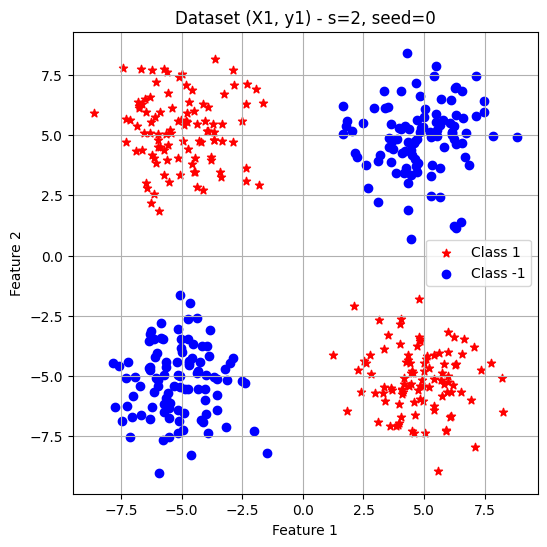

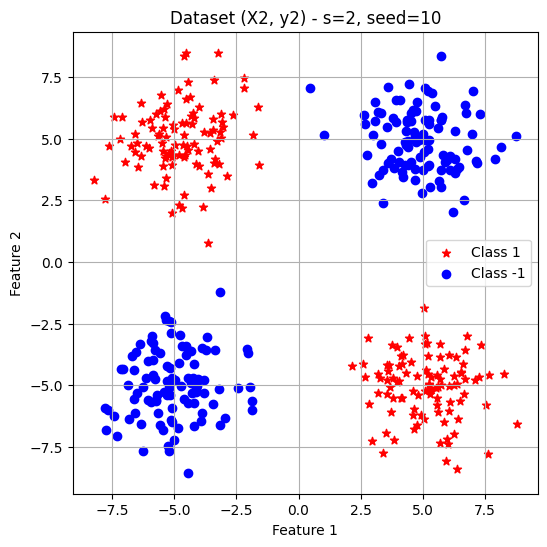

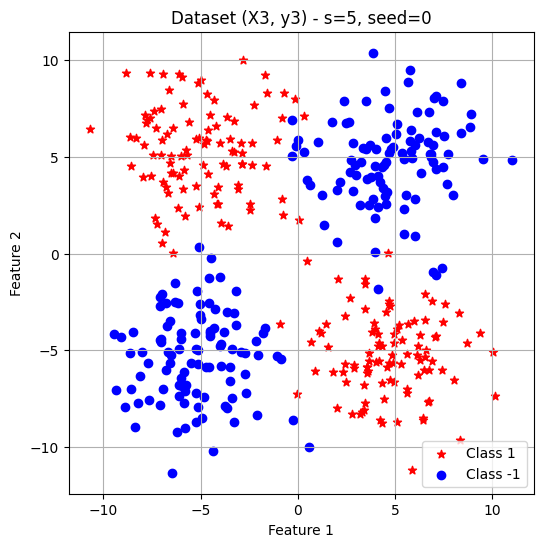

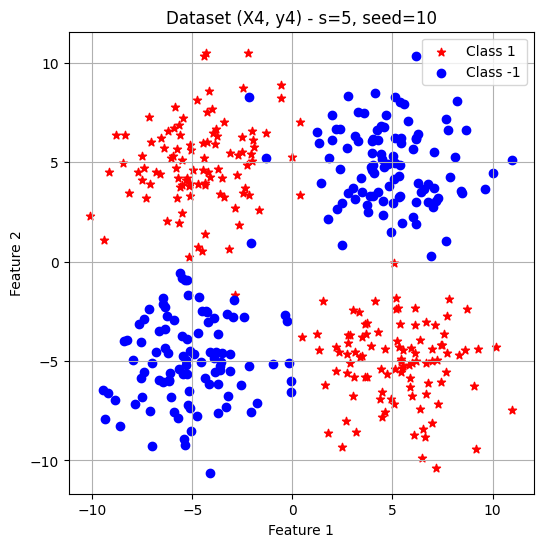

In [ ]:
# Define the correct mean matrix
m = np.array([
    [-5, +5, +5, -5],  # X-coordinates of cluster centers
    [+5, -5, +5, -5]   # Y-coordinates of cluster centers
])

N = 100  # Number of samples per class

# Generate datasets
X1, y1 = data_generator(m, s=2, N=N, seed=0)
X2, y2 = data_generator(m, s=2, N=N, seed=10)
X3, y3 = data_generator(m, s=5, N=N, seed=0)
X4, y4 = data_generator(m, s=5, N=N, seed=10)
def plot_data(X, y, title):
    """
    Plots the dataset with different colors for each class.

    Parameters:
    X (numpy.ndarray): Feature matrix (2, num_samples)
    y (numpy.ndarray): Labels (1, num_samples)
    title (str): Title of the plot

    Returns:
    None (displays the plot).
    """
    X=X.T
    plt.figure(figsize=(6, 6))
    plt.scatter(X[0, y.flatten() == 1], X[1, y.flatten() == 1],
                color='red', marker='*', label='Class 1')
    plt.scatter(X[0, y.flatten() == -1], X[1, y.flatten() == -1],
                color='blue', marker='o', label='Class -1')

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot all datasets
plot_data(X1, y1, "Dataset (X1, y1) - s=2, seed=0")
plot_data(X2, y2, "Dataset (X2, y2) - s=2, seed=10")
plot_data(X3, y3, "Dataset (X3, y3) - s=5, seed=0")
plot_data(X4, y4, "Dataset (X4, y4) - s=5, seed=10")


Epoch 100, Learning Rate: 0.010000
Epoch 200, Learning Rate: 0.010000
Epoch 300, Learning Rate: 0.010000
Epoch 400, Learning Rate: 0.010000
Epoch 500, Learning Rate: 0.010000
Epoch 600, Learning Rate: 0.010000
Epoch 700, Learning Rate: 0.010000
Epoch 800, Learning Rate: 0.010000
Epoch 900, Learning Rate: 0.010000
Epoch 1000, Learning Rate: 0.010000
Train Accuracy: 98.2500, Test Accuracy: 97.0000



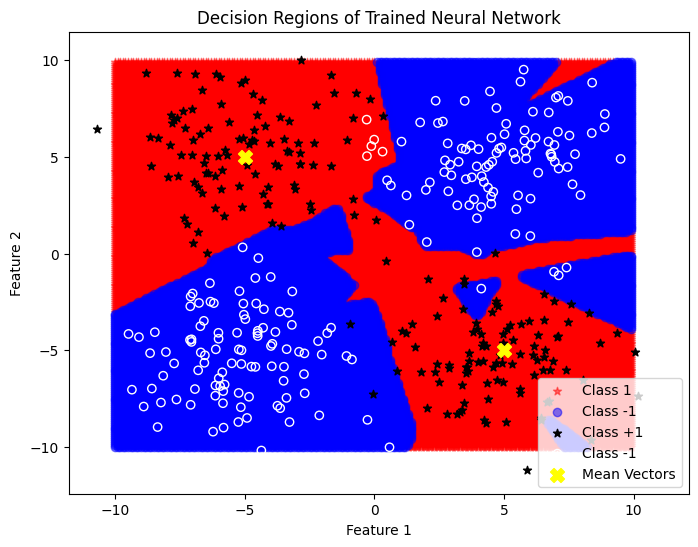

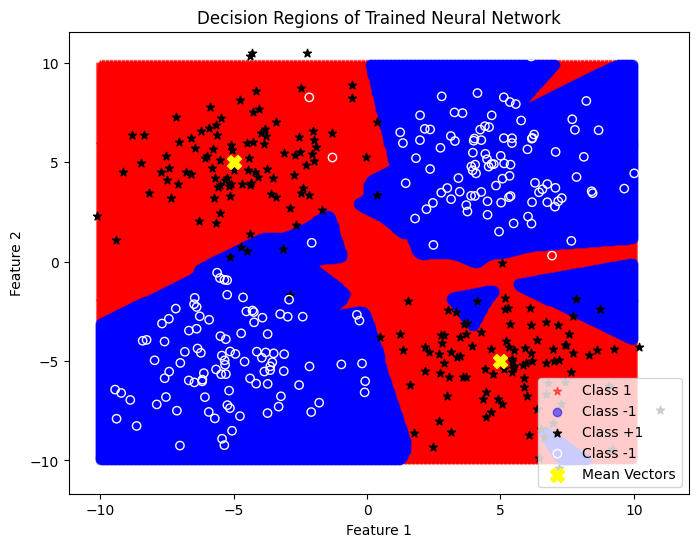

In [ ]:
# Initialize the neural network
nn = NeuralNetwork(input_dim=2, hidden_nodes=15)

nn.train(X3,y3,1,1000,[0.01,0,0,0,0])
A1 = nn.evaluate(X3, y3)
A2 = nn.evaluate(X4, y4)
print(f"Train Accuracy: {A1*100:.4f}, Test Accuracy: {A2*100:.4f}\n")

plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.1, rv=0.1, m=m, X=X3,y=y3)
plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.05, rv=0.05, m=m,X=X4,y=y4)

Epoch 100, Learning Rate: 0.001000
Epoch 200, Learning Rate: 0.001000
Epoch 300, Learning Rate: 0.001000
Epoch 400, Learning Rate: 0.001000
Epoch 500, Learning Rate: 0.001000
Epoch 600, Learning Rate: 0.001000
Epoch 700, Learning Rate: 0.001000
Epoch 800, Learning Rate: 0.001000
Epoch 900, Learning Rate: 0.001000
Epoch 1000, Learning Rate: 0.001000
Train Accuracy: 98.2500, Test Accuracy: 96.5000



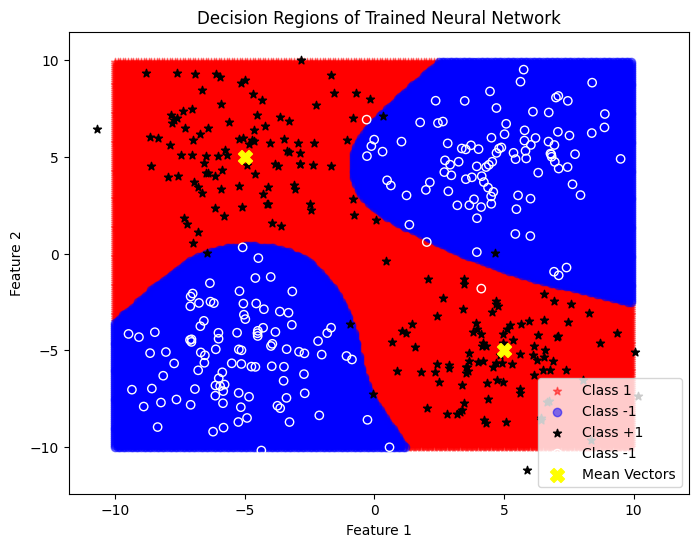

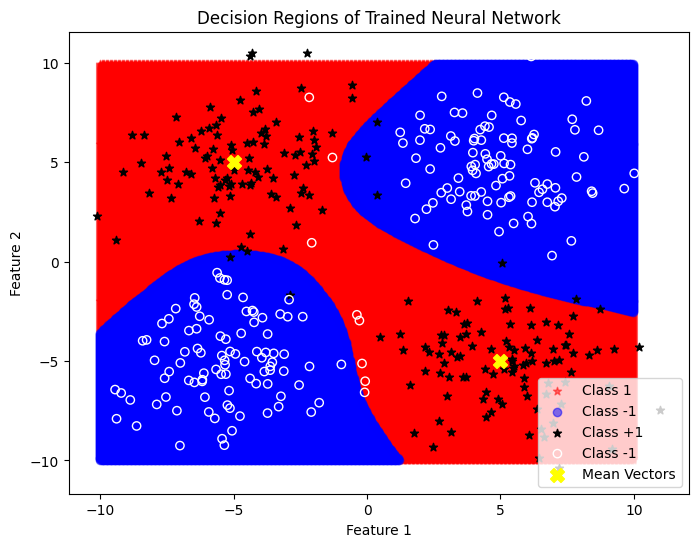

In [ ]:
# Initialize the neural network
nn = NeuralNetwork(input_dim=2, hidden_nodes=4)

nn.train(X3,y3,1,1000,[0.001,0,0,0,0])
A1 = nn.evaluate(X3, y3)
A2 = nn.evaluate(X4, y4)
print(f"Train Accuracy: {A1*100:.4f}, Test Accuracy: {A2*100:.4f}\n")

plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.1, rv=0.1, m=m, X=X3,y=y3)
plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.05, rv=0.05, m=m,X=X4,y=y4)

Epoch 100, Learning Rate: 0.010000
Epoch 200, Learning Rate: 0.010000
Epoch 300, Learning Rate: 0.010000
Epoch 400, Learning Rate: 0.010000
Epoch 500, Learning Rate: 0.010000
Epoch 600, Learning Rate: 0.010000
Epoch 700, Learning Rate: 0.010000
Epoch 800, Learning Rate: 0.010000
Epoch 900, Learning Rate: 0.010000
Epoch 1000, Learning Rate: 0.010000
Train Accuracy: 100.0000, Test Accuracy: 99.2500



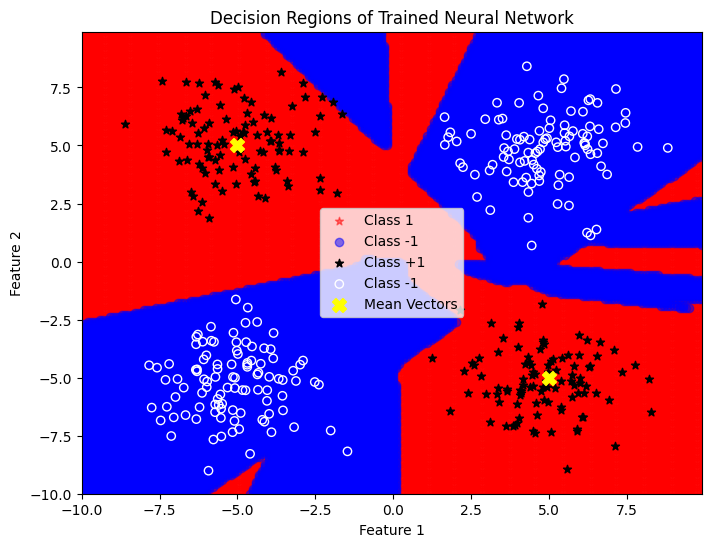

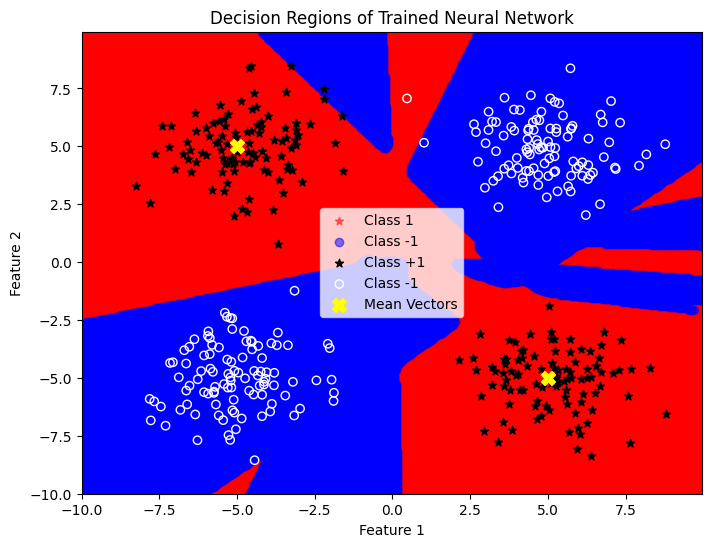

In [ ]:
# Initialize the neural network
nn = NeuralNetwork(input_dim=2, hidden_nodes=15)

nn.train(X1,y1,1,1000,[0.01,0,0,0,0])
A1 = nn.evaluate(X1, y1)
A2 = nn.evaluate(X2, y2)
print(f"Train Accuracy: {A1*100:.4f}, Test Accuracy: {A2*100:.4f}\n")

plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.1, rv=0.1, m=m, X=X1,y=y1)
plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.05, rv=0.05, m=m,X=X2,y=y2)

Epoch 100, Learning Rate: 0.010000
Epoch 200, Learning Rate: 0.010000
Epoch 300, Learning Rate: 0.010000
Train Accuracy: 100.0000, Test Accuracy: 99.2500



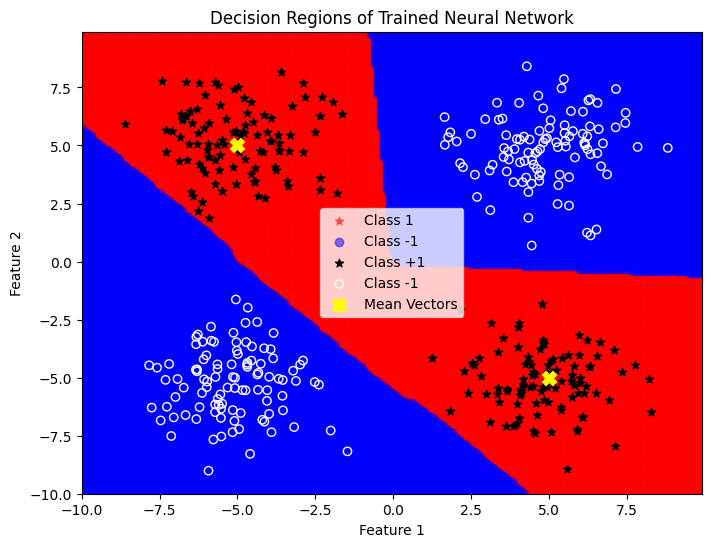

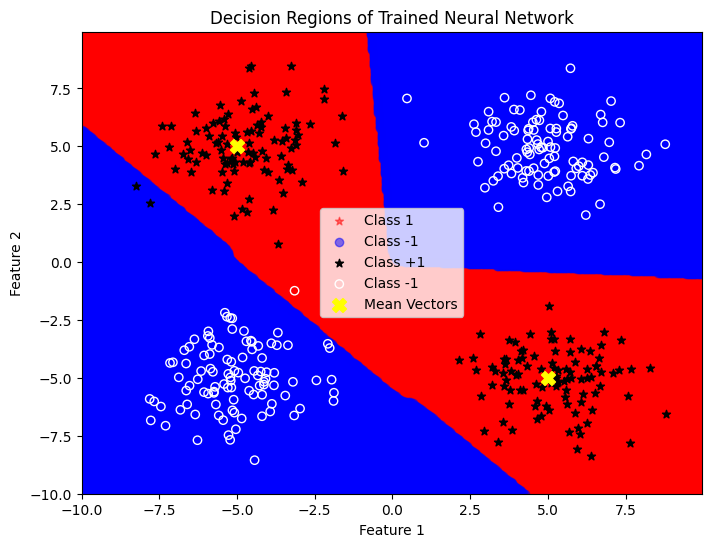

In [ ]:
# Initialize the neural network
nn = NeuralNetwork(input_dim=2, hidden_nodes=4)

nn.train(X1,y1,1,300,[0.01,0,0,0,0])
A1 = nn.evaluate(X1, y1)
A2 = nn.evaluate(X2, y2)
print(f"Train Accuracy: {A1*100:.4f}, Test Accuracy: {A2*100:.4f}\n")

plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.1, rv=0.1, m=m, X=X1,y=y1)
plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.05, rv=0.05, m=m,X=X2,y=y2)

Epoch 100, Learning Rate: 0.001000
Epoch 200, Learning Rate: 0.001000
Epoch 300, Learning Rate: 0.001000
Train Accuracy: 100.0000, Test Accuracy: 100.0000



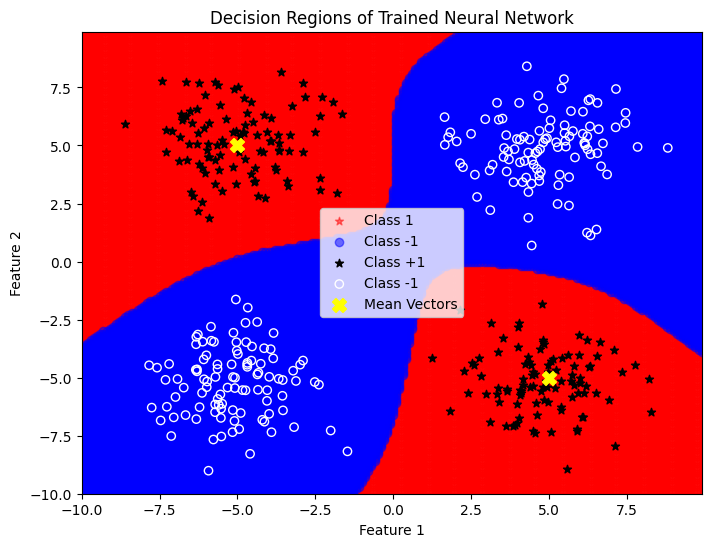

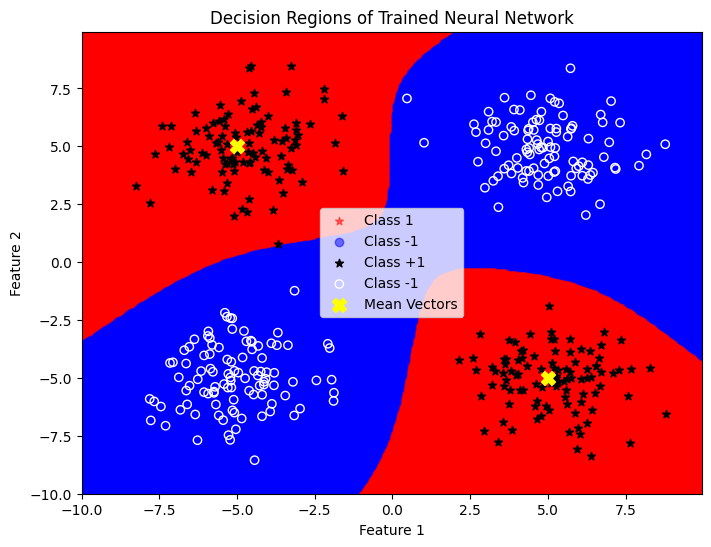

In [ ]:
# Initialize the neural network
nn = NeuralNetwork(input_dim=2, hidden_nodes=4)

nn.train(X1,y1,1,300,[0.001,0,0,0,0])
A1 = nn.evaluate(X1, y1)
A2 = nn.evaluate(X2, y2)
print(f"Train Accuracy: {A1*100:.4f}, Test Accuracy: {A2*100:.4f}\n")

plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.1, rv=0.1, m=m, X=X1,y=y1)
plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.05, rv=0.05, m=m,X=X2,y=y2)

Epoch 100, Learning Rate: 0.010000
Epoch 200, Learning Rate: 0.010000
Epoch 300, Learning Rate: 0.010000
Epoch 400, Learning Rate: 0.010000
Epoch 500, Learning Rate: 0.010000
Epoch 600, Learning Rate: 0.010000
Epoch 700, Learning Rate: 0.010000
Epoch 800, Learning Rate: 0.010000
Epoch 900, Learning Rate: 0.010000
Epoch 1000, Learning Rate: 0.010000
Train Accuracy: 100.0000, Test Accuracy: 98.7500



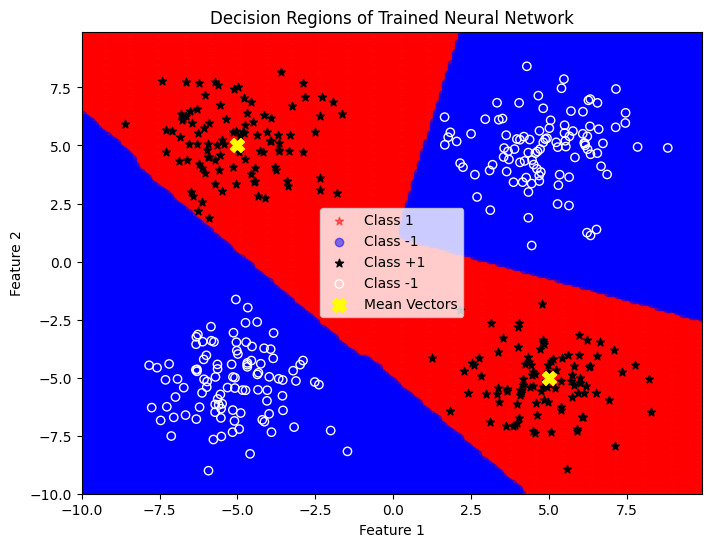

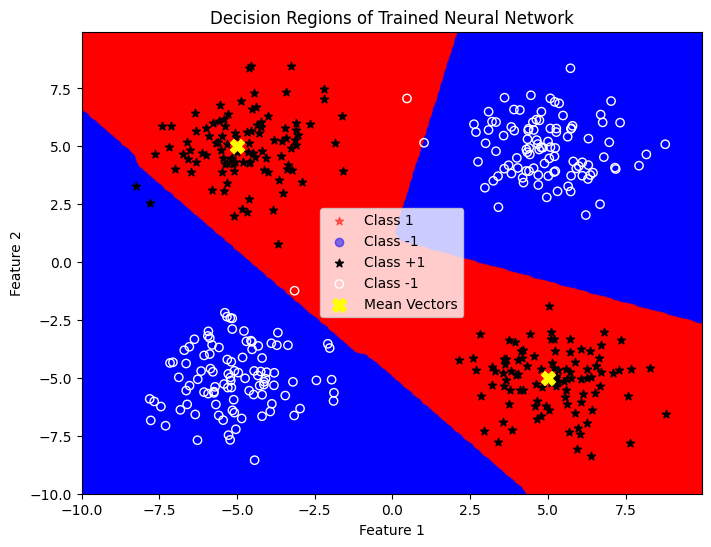

In [ ]:
# Initialize the neural network
nn = NeuralNetwork(input_dim=2, hidden_nodes=4)

nn.train(X1,y1,1,1000,[0.01,0,0,0,0])
A1 = nn.evaluate(X1, y1)
A2 = nn.evaluate(X2, y2)
print(f"Train Accuracy: {A1*100:.4f}, Test Accuracy: {A2*100:.4f}\n")

plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.1, rv=0.1, m=m, X=X1,y=y1)
plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.05, rv=0.05, m=m,X=X2,y=y2)

Epoch 100, Learning Rate: 0.001000
Epoch 200, Learning Rate: 0.001000
Epoch 300, Learning Rate: 0.001000
Epoch 400, Learning Rate: 0.001000
Epoch 500, Learning Rate: 0.001000
Epoch 600, Learning Rate: 0.001000
Epoch 700, Learning Rate: 0.001000
Epoch 800, Learning Rate: 0.001000
Epoch 900, Learning Rate: 0.001000
Epoch 1000, Learning Rate: 0.001000
Train Accuracy: 100.0000, Test Accuracy: 100.0000



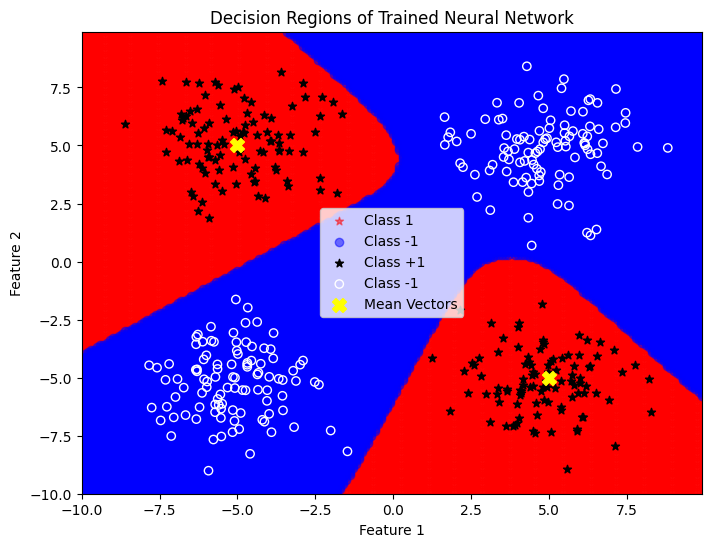

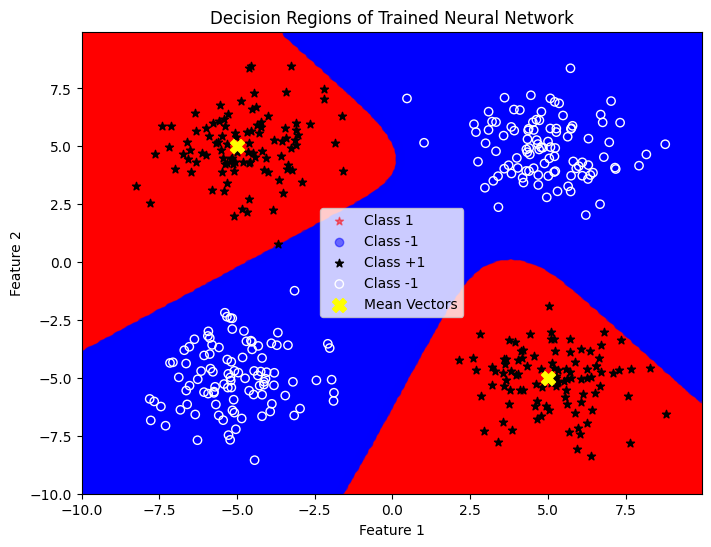

In [ ]:
# Initialize the neural network
nn = NeuralNetwork(input_dim=2, hidden_nodes=4)

nn.train(X1,y1,1,1000,[0.001,0,0,0,0])
A1 = nn.evaluate(X1, y1)
A2 = nn.evaluate(X2, y2)
print(f"Train Accuracy: {A1*100:.4f}, Test Accuracy: {A2*100:.4f}\n")

plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.1, rv=0.1, m=m, X=X1,y=y1)
plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.05, rv=0.05, m=m,X=X2,y=y2)

Epoch 100, Learning Rate: 0.000372
Epoch 200, Learning Rate: 0.000372
Epoch 300, Learning Rate: 0.000372
Train Accuracy: 100.0000, Test Accuracy: 99.7500



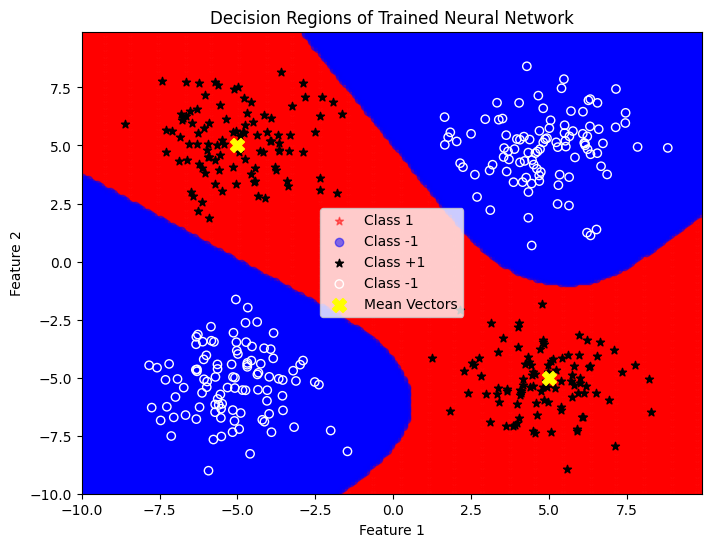

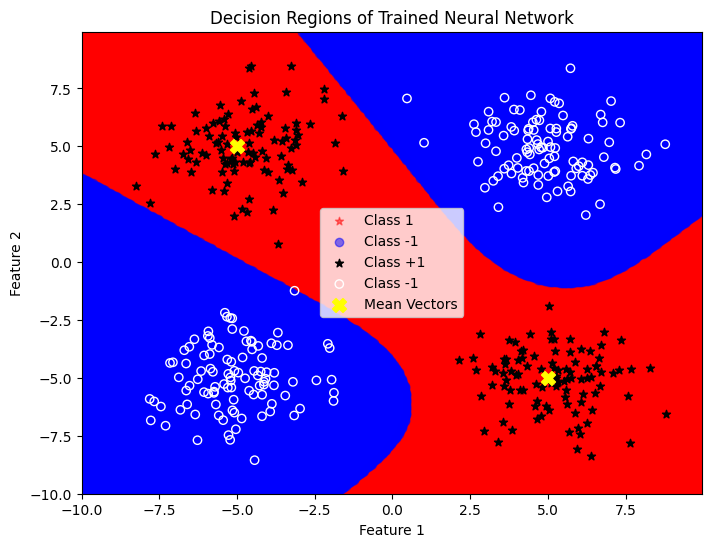

In [ ]:
# Initialize the neural network
nn = NeuralNetwork(input_dim=2, hidden_nodes=4)

nn.train(X1,y1,3,300,[0.001,0,1.05,0.7,1.04])
A1 = nn.evaluate(X1, y1)
A2 = nn.evaluate(X2, y2)
print(f"Train Accuracy: {A1*100:.4f}, Test Accuracy: {A2*100:.4f}\n")

plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.1, rv=0.1, m=m, X=X1,y=y1)
plot_dec_regions(net=nn, lh=-10, uh=10, lv=-10, uv=10, rh=0.05, rv=0.05, m=m,X=X2,y=y2)